# Stratified Sampling for HealthBench Hard Dataset

This notebook creates a **representative 200-sample subset** from the 1,000-sample HealthBench hard dataset using stratified random sampling by theme.

## Why Stratified Sampling?

- **Proportional representation**: Maintains the same distribution as the full dataset
- **No category bias**: Ensures rare themes (like `emergency_referrals`) aren't missed
- **Reproducible**: Fixed random seed (42) for consistent results

In [4]:
# !pip install matplotlib

In [5]:
import json
import random
import hashlib
import urllib.request
from pathlib import Path
from collections import defaultdict, Counter
import tempfile

import matplotlib.pyplot as plt
import numpy as np

# Configuration
DATASET_URL = "https://openaipublic.blob.core.windows.net/simple-evals/healthbench/hard_2025-05-08-21-00-10.jsonl"
OUTPUT_PATH = Path("../data/hard_200_sample_ids.json")
TARGET_SAMPLES = 200
RANDOM_SEED = 42

# Color palette for themes
THEME_COLORS = {
    'global_health': '#2ecc71',
    'context_seeking': '#3498db',
    'hedging': '#9b59b6',
    'health_data_tasks': '#e74c3c',
    'communication': '#f39c12',
    'complex_responses': '#1abc9c',
    'emergency_referrals': '#e91e63'
}

## 1. Load the Full Dataset

In [6]:
def download_or_load_dataset(url: str) -> list[dict]:
    """Download dataset or load from cache."""
    cache_dir = Path(tempfile.gettempdir()) / "healthbench_cache"
    filename = hashlib.sha256(url.encode()).hexdigest() + ".jsonl"
    cache_path = cache_dir / filename

    if cache_path.exists():
        print(f"Loading from cache: {cache_path}")
        with open(cache_path, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]

    print(f"Downloading dataset from: {url}")
    cache_dir.mkdir(exist_ok=True, parents=True)

    with urllib.request.urlopen(url) as response:
        content = response.read()

    cache_path.write_bytes(content)

    return [json.loads(line) for line in content.decode('utf-8').split('\n') if line.strip()]


def get_theme(example_tags: list[str]) -> str:
    """Extract theme from example_tags."""
    for tag in example_tags:
        if tag.startswith('theme:'):
            return tag.replace('theme:', '')
    return 'unknown'


# Load the dataset
data = download_or_load_dataset(DATASET_URL)
print(f"\nTotal samples in hard dataset: {len(data)}")

Loading from cache: /var/folders/ph/kfdm7zqn361dvr4dxmzjdh680000gp/T/healthbench_cache/df365a255b27e3d06a0eb5de21ce7052579d2f604ee49b29142f103246770835.jsonl

Total samples in hard dataset: 1000


## 2. Original Distribution (1,000 samples)

Let's visualize the theme distribution in the full dataset.

In [7]:
# Count themes in full dataset
full_theme_counts = Counter()
for sample in data:
    theme = get_theme(sample.get('example_tags', []))
    full_theme_counts[theme] += 1

# Sort by count (descending)
sorted_themes = sorted(full_theme_counts.items(), key=lambda x: -x[1])
themes = [t[0] for t in sorted_themes]
counts = [t[1] for t in sorted_themes]
colors = [THEME_COLORS.get(t, '#95a5a6') for t in themes]

print("Full Dataset Theme Distribution:")
print("-" * 50)
for theme, count in sorted_themes:
    pct = count / len(data) * 100
    print(f"  {theme:<20} {count:>4} samples ({pct:5.1f}%)")

Full Dataset Theme Distribution:
--------------------------------------------------
  global_health         280 samples ( 28.0%)
  context_seeking       179 samples ( 17.9%)
  hedging               167 samples ( 16.7%)
  health_data_tasks     115 samples ( 11.5%)
  communication         111 samples ( 11.1%)
  complex_responses      82 samples (  8.2%)
  emergency_referrals    66 samples (  6.6%)


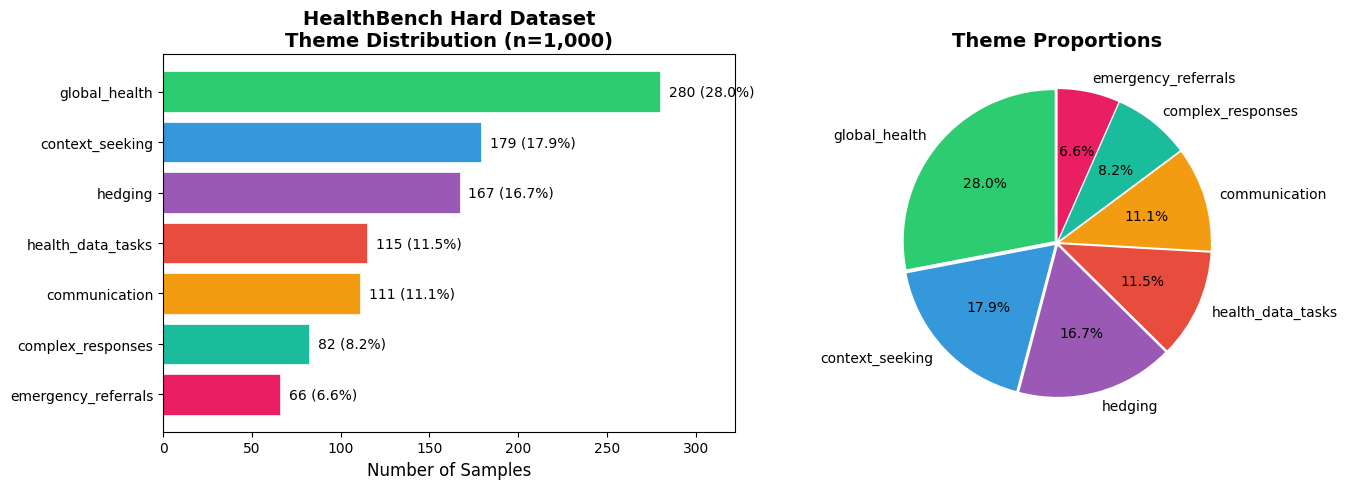


Saved: ../data/full_dataset_distribution.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
bars = ax1.barh(themes[::-1], counts[::-1], color=colors[::-1], edgecolor='white', linewidth=0.5)
ax1.set_xlabel('Number of Samples', fontsize=12)
ax1.set_title('HealthBench Hard Dataset\nTheme Distribution (n=1,000)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, max(counts) * 1.15)

# Add count labels
for bar, count in zip(bars, counts[::-1]):
    ax1.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{count} ({count/10:.1f}%)', va='center', fontsize=10)

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    counts, 
    labels=themes,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.02] * len(themes)
)
ax2.set_title('Theme Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/full_dataset_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: ../data/full_dataset_distribution.png")

## 3. Stratified Sampling

Now we'll create a 200-sample subset that maintains the same proportions.

In [9]:
def stratified_sample(data: list[dict], target_total: int, seed: int) -> list[str]:
    """
    Perform stratified random sampling by theme.
    
    Returns list of prompt_ids.
    """
    random.seed(seed)

    # Group by theme
    theme_groups = defaultdict(list)
    for sample in data:
        theme = get_theme(sample.get('example_tags', []))
        theme_groups[theme].append(sample['prompt_id'])

    total_samples = len(data)
    selected_ids = []
    sampling_details = []

    # Calculate and sample for each theme
    for theme in sorted(theme_groups.keys()):
        group_ids = theme_groups[theme]
        group_size = len(group_ids)

        # Proportional target (with rounding)
        target_count = round(group_size / total_samples * target_total)

        # Sample
        sampled = random.sample(group_ids, min(target_count, group_size))
        selected_ids.extend(sampled)
        
        sampling_details.append({
            'theme': theme,
            'original': group_size,
            'sampled': len(sampled),
            'original_pct': group_size / total_samples * 100,
            'sampled_pct': len(sampled) / target_total * 100
        })

    # Adjust if we have slightly more or fewer than target due to rounding
    if len(selected_ids) > target_total:
        random.shuffle(selected_ids)
        selected_ids = selected_ids[:target_total]
    elif len(selected_ids) < target_total:
        remaining_ids = [s['prompt_id'] for s in data if s['prompt_id'] not in selected_ids]
        additional = random.sample(remaining_ids, target_total - len(selected_ids))
        selected_ids.extend(additional)

    return selected_ids, sampling_details


# Perform stratified sampling
selected_ids, sampling_details = stratified_sample(data, TARGET_SAMPLES, RANDOM_SEED)

print(f"Stratified Sampling Results (seed={RANDOM_SEED})")
print("=" * 70)
print(f"{'Theme':<20} {'Original':>10} {'Sampled':>10} {'Orig %':>10} {'Samp %':>10}")
print("-" * 70)
for d in sorted(sampling_details, key=lambda x: -x['original']):
    print(f"{d['theme']:<20} {d['original']:>10} {d['sampled']:>10} {d['original_pct']:>9.1f}% {d['sampled_pct']:>9.1f}%")
print("-" * 70)
print(f"{'TOTAL':<20} {len(data):>10} {len(selected_ids):>10}")

Stratified Sampling Results (seed=42)
Theme                  Original    Sampled     Orig %     Samp %
----------------------------------------------------------------------
global_health               280         56      28.0%      28.0%
context_seeking             179         36      17.9%      18.0%
hedging                     167         33      16.7%      16.5%
health_data_tasks           115         23      11.5%      11.5%
communication               111         22      11.1%      11.0%
complex_responses            82         16       8.2%       8.0%
emergency_referrals          66         13       6.6%       6.5%
----------------------------------------------------------------------
TOTAL                      1000        200


## 4. Compare Original vs Sampled Distribution

In [10]:
# Get actual sampled counts (recalculate to ensure accuracy)
selected_set = set(selected_ids)
sampled_theme_counts = Counter()
for sample in data:
    if sample['prompt_id'] in selected_set:
        theme = get_theme(sample.get('example_tags', []))
        sampled_theme_counts[theme] += 1

# Prepare data for comparison plot
themes_sorted = [t[0] for t in sorted_themes]  # Use same order as before
original_pcts = [full_theme_counts[t] / len(data) * 100 for t in themes_sorted]
sampled_pcts = [sampled_theme_counts[t] / len(selected_ids) * 100 for t in themes_sorted]

# Calculate difference
diff_pcts = [s - o for s, o in zip(sampled_pcts, original_pcts)]

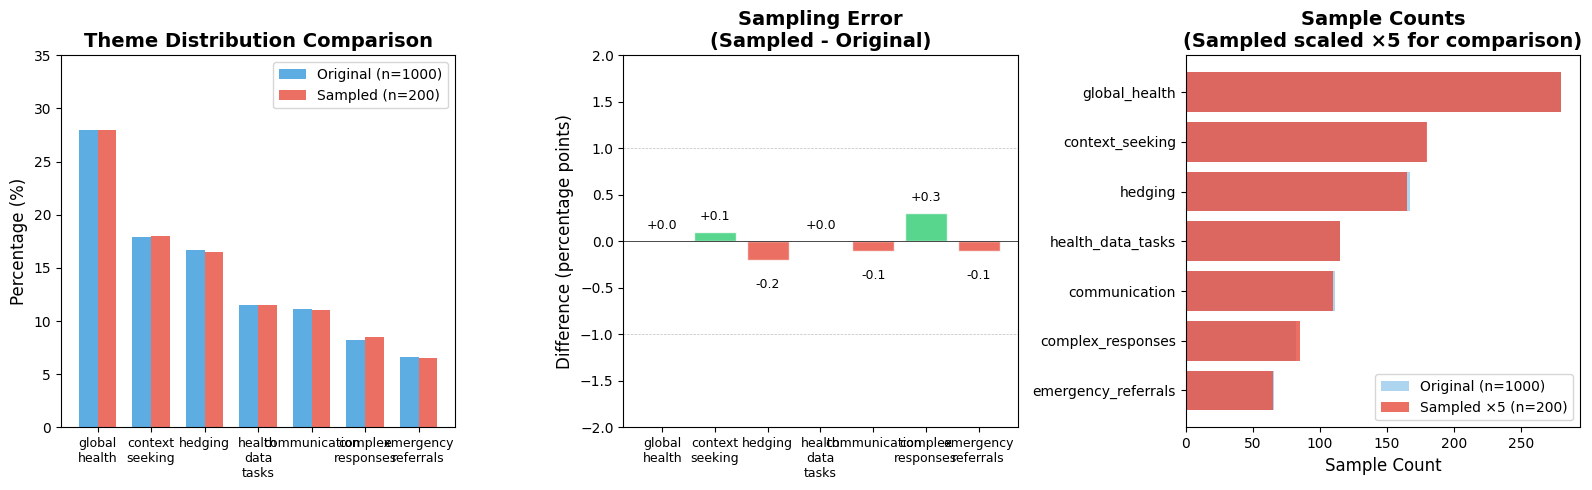


Saved: ../data/stratified_sampling_comparison.png


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x = np.arange(len(themes_sorted))
width = 0.35

# Grouped bar chart
ax1 = axes[0]
bars1 = ax1.bar(x - width/2, original_pcts, width, label='Original (n=1000)', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, sampled_pcts, width, label='Sampled (n=200)', color='#e74c3c', alpha=0.8)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Theme Distribution Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([t.replace('_', '\n') for t in themes_sorted], fontsize=9)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 35)

# Difference chart
ax2 = axes[1]
colors_diff = ['#2ecc71' if d >= 0 else '#e74c3c' for d in diff_pcts]
bars3 = ax2.bar(x, diff_pcts, color=colors_diff, alpha=0.8, edgecolor='white')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=1, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_ylabel('Difference (percentage points)', fontsize=12)
ax2.set_title('Sampling Error\n(Sampled - Original)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([t.replace('_', '\n') for t in themes_sorted], fontsize=9)
ax2.set_ylim(-2, 2)

# Add value labels
for bar, val in zip(bars3, diff_pcts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1 if val >= 0 else bar.get_height() - 0.2,
             f'{val:+.1f}', ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

# Sample counts comparison
ax3 = axes[2]
original_counts = [full_theme_counts[t] for t in themes_sorted]
sampled_counts = [sampled_theme_counts[t] for t in themes_sorted]

ax3.barh(themes_sorted[::-1], original_counts[::-1], color='#3498db', alpha=0.4, label='Original (n=1000)')
ax3.barh(themes_sorted[::-1], [c * 5 for c in sampled_counts[::-1]], color='#e74c3c', alpha=0.8, label='Sampled ×5 (n=200)')
ax3.set_xlabel('Sample Count', fontsize=12)
ax3.set_title('Sample Counts\n(Sampled scaled ×5 for comparison)', fontsize=14, fontweight='bold')
ax3.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../data/stratified_sampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: ../data/stratified_sampling_comparison.png")

## 5. Save the Stratified Sample

In [12]:
# Save output
OUTPUT_PATH.parent.mkdir(exist_ok=True, parents=True)

output_data = {
    "description": "Stratified random sample of HealthBench hard dataset",
    "total_samples": len(selected_ids),
    "source": DATASET_URL,
    "random_seed": RANDOM_SEED,
    "stratification": "theme (7 categories)",
    "prompt_ids": sorted(selected_ids)
}

with open(OUTPUT_PATH, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"Saved {len(selected_ids)} prompt IDs to: {OUTPUT_PATH}")
print(f"\nFile size: {OUTPUT_PATH.stat().st_size / 1024:.1f} KB")

Saved 200 prompt IDs to: ../data/hard_200_sample_ids.json

File size: 8.9 KB


## Summary

### What we created:
- **200 stratified samples** from the 1,000-sample HealthBench hard dataset
- Theme proportions preserved within ±1 percentage point

### Usage:
```bash
# Run baseline on 200 samples
python -m simple-evals.simple_evals --model=gpt-4o-mini --eval=healthbench_hard \
    --sample-file=data/hard_200_sample_ids.json --n-threads=10

# Run BODHI on 200 samples  
python -m simple-evals.simple_evals --model=gpt-4o-mini --eval=healthbench_hard \
    --sample-file=data/hard_200_sample_ids.json --n-threads=10 --use-bodhi
```
